Import libraries

In [1]:
import os
import fitsio as ft
import numpy as np
import matplotlib.pyplot as plt
import logging 
from scipy.optimize import curve_fit, minimize

import sys
sys.path.append("/global/homes/a/arosado/photometry/")
from photometry import Catalogue, utils, setup_logging

#logger = logging.getLogger('DA02')
#setup_logging()

# Functions

In [2]:
def plot_dndz_variations_test(ax, z, samples, weights=None, zbins=np.linspace(0.6, 1.5, 18), linestyle='-', labels=None):

    usamples = np.unique(samples)
    nsamples = len(usamples)
    if labels is None:
        labels = [None]*nsamples
    
    dndzw = np.histogram(z, bins=zbins, weights=weights)[0]
    dndz = np.histogram(z, bins=zbins)[0]
    perr = 1./np.sqrt(dndz)*np.sqrt(nsamples)
    mid = (zbins[:-1] + zbins[1:])/2.
    ax.fill_between(mid, -perr, perr, color='gray')
    
    dndz_list = []
    
    for isample, (sample, label) in enumerate(zip(usamples, labels)):
        #print(isample,(sample,label), samples)
        mask = samples == sample
        #print(len(z[mask]))
        dndzw_sample = np.histogram(z[mask], bins=zbins, weights=weights[mask] if weights is not None else None)[0]
        ratio = dndzw_sample.sum()/dndzw.sum()
        toplot =  1./ratio*dndzw_sample/dndzw - 1.
        #print(toplot)
        dndz_list.append(toplot)
        ax.plot(mid,toplot, color='C{:d}'.format(isample), linestyle=linestyle, label=label)
    
    ax.set_xlabel('redshift')
    ax.set_ylabel('relative change in n(z)')
    ax.grid(True)
    ax.set_ylim(-0.3, 0.3)
    #print(dndz_list)
    return mid, dndz_list

In [3]:
def make_table(z, depth, dndz, depth_label=''):
    from astropy.table import Table, Column
    zl = np.concatenate([z for i in range(len(dndz))])
    dl = np.concatenate([np.full(dndz[i].size,depth[i]) for i in range(len(dndz))])
    dndzl = np.concatenate(dndz)
    t = Table([zl,dl,dndzl], names=('z',depth_label,'dndz') )
    return t

# plotting dndz

In [4]:
plot_dir = 'plots'

run = 'south'
region = run[0].upper()
base_dir = '/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/'

test_dir = '/global/cscratch1/sd/arosado/legacysim_fitting'
legacysim_data, h = ft.read(f'{test_dir}/legacysim_data_{run}.fits', header=True)
data = ft.read(f'{test_dir}/data_{run}.fits')

In [5]:
bins = 51

mean depth per bin (depth_r): [186.78526, 282.5174, 341.4434, 418.4132, 676.3567]
median depth per bin (depth_r): [199.1338, 284.7622, 340.27487, 416.2537, 561.1151]


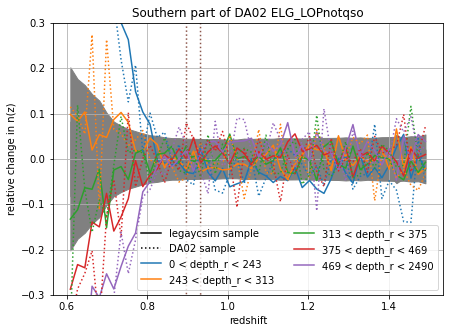

In [6]:
for prefix in ['ELG_LOPnotqso']:#,'ELG']:
    for column, name in [('GALDEPTH_R', 'depth_r')]:#, ('GALDEPTH_G', 'depth_g'), ('EBV', 'ebv')][:-1]:
        z = legacysim_data['INPUT_HSC_MIZUKI_PHOTOZ_BEST']
        depth = legacysim_data[column]
        quantiles = np.quantile(depth, q=np.linspace(0., 1., 6))
        #print(quantiles)
        labels = ['{:.0f} < {} < {:.0f}'.format(low, name, high) for low, high in zip(quantiles[:-1], quantiles[1:])]
        #print(labels)
        samples = np.clip(np.digitize(depth, quantiles) - 1, 0, len(quantiles) - 1)
        
        #
        d_mean_list = []
        d_median_list = []
        #print(min(depth), max(depth))
        usamples = np.unique(samples)
        nsamples = len(usamples)
        for sample in usamples[:nsamples-1]:
            mask = (sample == samples)
            #print(depth[mask].size)
            #print(min(depth[mask]), max(depth[mask]))
            depth_mean = depth[mask].mean()
            depth_median = np.median(depth[mask])
            d_mean_list.append(depth_mean)
            d_median_list.append(depth_median)
        print(f'mean depth per bin ({name}): {d_mean_list}')
        print(f'median depth per bin ({name}): {d_median_list}')
        #
        
        ax = plt.gca()
        fig = plt.gcf()
        fig.set_size_inches(7, 5)
        ax.plot([], [], linestyle='-', color='k', label='legaycsim sample')
        ax.plot([], [], linestyle=':', color='k', label='DA02 sample')
        mid, l = plot_dndz_variations_test(ax, z, samples, zbins=np.linspace(0.6, 1.5, bins), linestyle='-', labels=labels)

        #
        if name=='depth_r':
            t1 = make_table(mid,d_mean_list,l,depth_label=name)
            labels1 = labels
        elif name=='depth_g':
            t2 = make_table(mid,d_median_list,l,depth_label=name)
            labels2 = labels
        #
        
        data_full = data
        data_clustering = Catalogue.load(os.path.join(base_dir, '{}zdone_clustering.dat.fits'.format(prefix)))
        ind1, ind2 = utils.overlap(data_clustering['TARGETID'], data_full['TARGETID'])
        data_clustering = data_clustering[ind1]
        z = data_clustering['Z']
        weights = data_clustering['WEIGHT_COMP']
        depth = data_full[column][ind2]
        samples = np.clip(np.digitize(depth, quantiles) - 1, 0, len(quantiles) - 1)
        _,_ = plot_dndz_variations_test(ax, z, samples, zbins=np.linspace(0.6, 1.5, bins), weights=weights, linestyle=':')
        ax.set_title('Southern part of DA02 {}'.format(prefix))

        ax.legend(loc=4, ncol=2)
        filename = os.path.join(plot_dir, 'dndz_{}_{}_{}.png'.format(prefix, run, name))
        #fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=200)
        plt.show()

# Fit redshift and depth at once
objective function will have $F(z)*G(depth)$
We look at 4 different models, 3 have polynomial form, while one has exponential form.

In [7]:
def objective1(X, a, b, c, d, e, f, g):
    x1, x2 = X
    return (a*x1 + b*x1**2 + c) * (d*x2 + e*x2**2 + f*x2**3 + g)

In [8]:
def objective2(X, a, b, c, d, e, f, g):
    x1, x2 = X
    return  (b * np.exp(-a*x1) + c) * (d*x2 + e*x2**2 + f*x2**3 + g)

In [9]:
def objective3(X, a, b, c, d, e, f, g):
    x1, x2 = X
    return (a*x1 + b*x1**2 + c*x1**3 + d) * (e*x2 + f*x2**2 + g)

In [10]:
def objective4(X, a, b, c, d, e, f, g, h):
    x1, x2 = X
    return (a*x1 + b*x1**2 + c*x1**3 + d) * (e*x2 + f*x2**2 + g*x2**3 + h)

In [11]:
# choose legacysim data to use for fitting
name = 'depth_r' 
if name=='depth_r':
    t = t1
    labels = labels1
elif name=='depth_g':
    t = t2
    labels = labels2

In [12]:
# choose the input and output variables
x1, x2, y = t['z'], t[f'{name}'], t['dndz']

In [13]:
# curve fit
popt_list = []
popt, _ = curve_fit(objective1, (x1,x2), y)
popt_list.append(popt)
popt, _ = curve_fit(objective2, (x1,x2), y)
popt_list.append(popt)
popt, _ = curve_fit(objective3, (x1,x2), y)
popt_list.append(popt)
popt, _ = curve_fit(objective4, (x1,x2), y)
popt_list.append(popt)

In [14]:
# summarize the parameter values
#a,b,c,d,e,f = popt
for i in range(4):
    print(popt_list[i])
#print(f'y = ({a:.5f} * x_1 + {b:.5f} * [x_1]^2 + {c:.5f}) * ({d:.5f} * x_2 + {e:.5f})')

[-9.03654460e-01  3.83860821e-01  5.12842631e-01 -1.74577466e-01
  3.36665611e-04 -2.19375724e-07  2.82554420e+01]
[ 8.75193234e+00 -4.94650157e-03  1.23323735e-06  1.12685940e+03
 -2.17488183e+00  1.41572106e-03 -1.82042405e+05]
[-6.22101714e+00  5.26843478e+00 -1.46159885e+00  2.39350374e+00
 -4.26927907e-02  3.68714940e-05  9.94414664e+00]
[ 3.43593842e-01 -2.90910152e-01  8.06836389e-02 -1.32221856e-01
  1.81982688e+00 -3.49946661e-03  2.27289310e-06 -2.95010960e+02]


In [15]:
#define a sequence of inputs between the smallest and largest known inputs
z_line = np.linspace(0.6, 1.5, bins)
depth_line = np.full_like(z_line, x2[0])

In [16]:
results = []
y_line = objective1((z_line,depth_line), *popt_list[0])
results.append(y_line)
y_line = objective2((z_line,depth_line), *popt_list[1])
results.append(y_line)
y_line = objective3((z_line,depth_line), *popt_list[2])
results.append(y_line)
y_line = objective4((z_line,depth_line), *popt_list[3])
results.append(y_line)

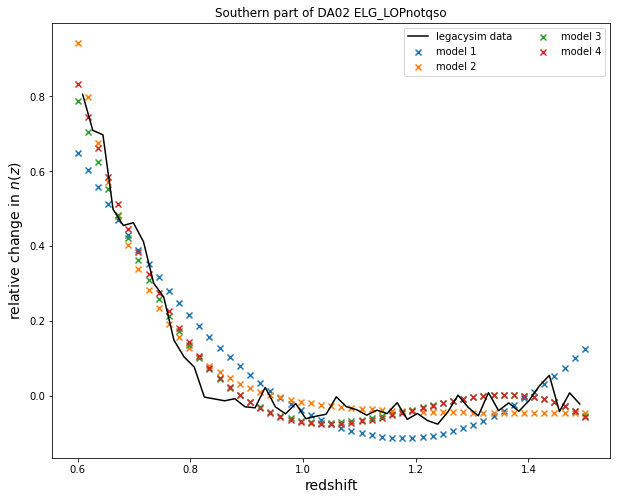

In [17]:
fig = plt.figure(figsize=(10,8))
plt.plot(x1[:(bins-1)], y[(bins-1)*0:(bins-1)*1], color='k', label='legacysim data')
for i in range(4):
    plt.scatter(z_line, results[i], marker='x', label=f'model {i+1}')

#plt.ylim(-0.3,0.3)
plt.title('Southern part of DA02 {}'.format(prefix))
#plt.ylabel('models mult. by some coeff', fontsize=14)
plt.ylabel(r'relative change in $n(z)$', fontsize=14)
plt.xlabel(r'redshift',fontsize=14)
plt.legend(loc=1, ncol=2)
plt.show()

From the tests done above, we can see that the `objective4` gives the best model for the moment.

$$
F(z)*G(\gamma) = (az + bz^2 + cz^3 + d) \cdot (e\gamma + f\gamma^2 + g\gamma^3 + h)
$$

where $\gamma$ is depth.

In [18]:
y_line = objective4((x1,x2), *popt_list[3])

In [19]:
y.size

250

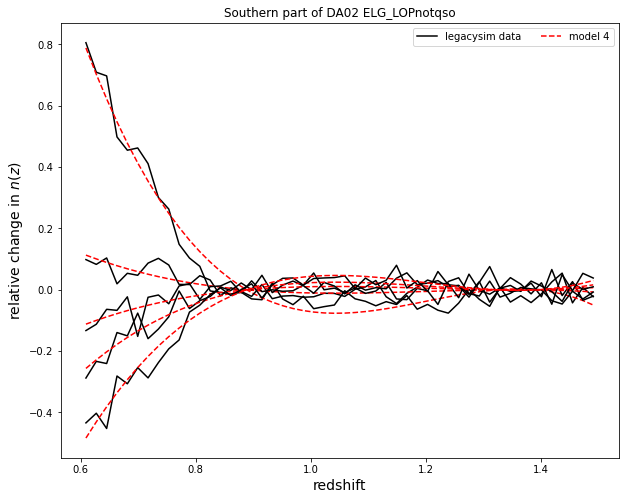

In [20]:
fig = plt.figure(figsize=(10,8))
plt.plot([],[], color='k', label='legacysim data')
plt.plot([],[], color='r', ls='--', label=f'model {4}')

for i in range(5):
    plt.plot(x1[:bins-1], y[(bins-1)*i:(bins-1)*(i+1)], color='k')
    plt.plot(x1[:bins-1], y_line[(bins-1)*i:(bins-1)*(i+1)], color='r', ls='--')
    
plt.title('Southern part of DA02 {}'.format(prefix))
plt.ylabel(r'relative change in $n(z)$', fontsize=14)
plt.xlabel(r'redshift',fontsize=14)
plt.legend(loc=1, ncol=2)
plt.show()

In [ ]:
def calc_xi2():
    

In [28]:
def objective2(X, a, b, c, d, e, f, g):
    x1, x2 = X
    return  (b * np.exp(-a*x1) + c) * (d*x2 + e*x2**2 + f*x2**3 + g)

Model 2 (exponential fit):
number of bins: 250
number of free parameters: 7
reduced chi2: 0.0011963235849521562

Model 4 (polynomial fit):
number of bins: 250
number of free parameters: 8
reduced chi2: 0.0009770518852008359


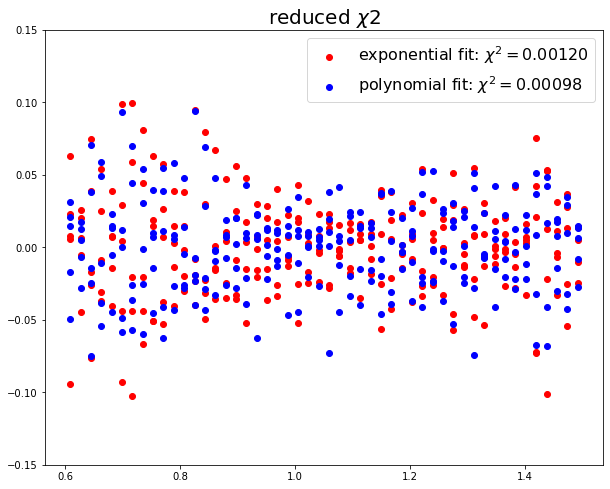

In [33]:

fig = plt.figure(figsize=(10,8))

print('Model 2 (exponential fit):')
res = curve_fit(objective2, (x1,x2), y, full_output=True)
#s_sq = ((test[2]['fvec']/yerr)**2).sum()
N, n = len(res[2]['fvec']), len(res[0])
print(f'number of bins: {N}')
print(f'number of free parameters: {n}')
s_sq = (res[2]['fvec']**2).sum() / (N-n)
print(f'reduced chi2: {s_sq}')
#plt.plot(x1,objective2((x1,x2), *test[0]))
plt.scatter(x1,res[2]['fvec'], color='r', label=f'exponential fit: $\chi^2 = {s_sq:.5f}$')

print('')
print('Model 4 (polynomial fit):')
res2 = curve_fit(objective4, (x1,x2), y, full_output=True)
#s_sq2 = ((test2[2]['fvec']/yerr)**2).sum()
N2, n2 = len(res2[2]['fvec']), len(res2[0])
print(f'number of bins: {N2}')
print(f'number of free parameters: {n2}')
s_sq2 = ((res2[2]['fvec'])**2).sum() / (N2-n2)
print(f'reduced chi2: {s_sq2}')
plt.scatter(x1,res2[2]['fvec'], color='b', label=f'polynomial fit: $\chi^2 = {s_sq2:.5f}$')

plt.title('reduced $\chi2$', fontsize=20)
plt.legend(fontsize=16)
plt.ylim(-0.15, 0.15)
plt.show()

In [22]:
# here we are trying out model 2 seems to fit only one depth bin at a time
fig = plt.figure(figsize=(10,8))

# choose the input and output variables
x1, x2, y = t['z'], t[f'{name}'], t['dndz']

#define a sequence of inputs between the smallest and largest known inputs
z_line = np.linspace(0.6, 1.5, bins)
depth_line = np.full_like(z_line, x2[0])

i, j = (bins-1)*0, (bins-1)*1

#popt, _ = curve_fit(objective2, (x1[i:j],x2[i:j]), y[i:j])

print(popt)

#y_line = objective2((x1[i:j],x2[i:j]), *popt)
y_line = objective2((x1,x2), *popt)

#plt.plot(x1[i:j],y[i:j])
plt.plot(x1,y)
#plt.scatter(x1[i:j], y_line, marker='x', color='r')
plt.scatter(x1, y_line, marker='x', color='r')
plt.scatter(x1, y_line, marker='x', color='r')
#plt.ylim(-.8,.8)

[ 3.43593842e-01 -2.90910152e-01  8.06836389e-02 -1.32221856e-01
  1.81982688e+00 -3.49946661e-03  2.27289310e-06 -2.95010960e+02]


TypeError: objective2() takes 7 positional arguments but 9 were given

<Figure size 720x576 with 0 Axes>

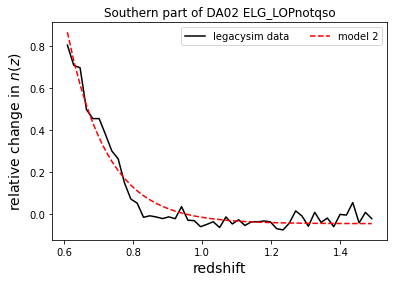

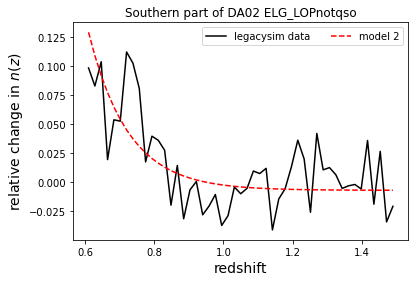

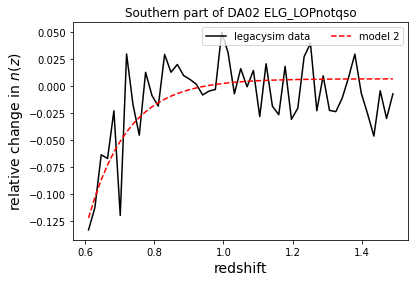

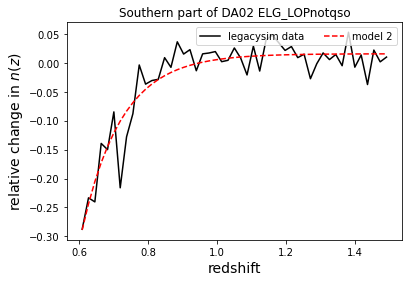

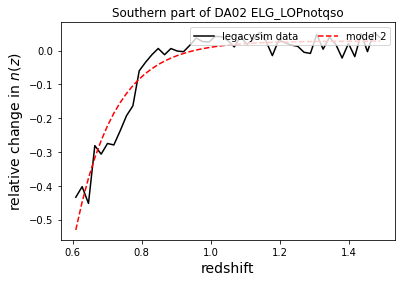

In [23]:
for i in range(5):
    #fig = plt.figure(figsize=(10,8))
    plt.plot([],[], color='k', label='legacysim data')
    plt.plot([],[], color='r', ls='--', label=f'model {2}')
    
    plt.plot(x1[:bins-1], y[(bins-1)*i:(bins-1)*(i+1)], color='k')
    plt.plot(x1[:bins-1], y_line[(bins-1)*i:(bins-1)*(i+1)], color='r', ls='--')
    
    plt.title('Southern part of DA02 {}'.format(prefix))
    plt.ylabel(r'relative change in $n(z)$', fontsize=14)
    plt.xlabel(r'redshift',fontsize=14)
    plt.legend(loc=1, ncol=2)
    plt.show()

In [20]:
x1_line = np.concatenate([np.linspace(min(x1),max(x1),num=49) for i in range(5)])
y_line = objective2((x1_line,x2), *popt_list[3])

TypeError: objective2() takes 8 positional arguments but 9 were given

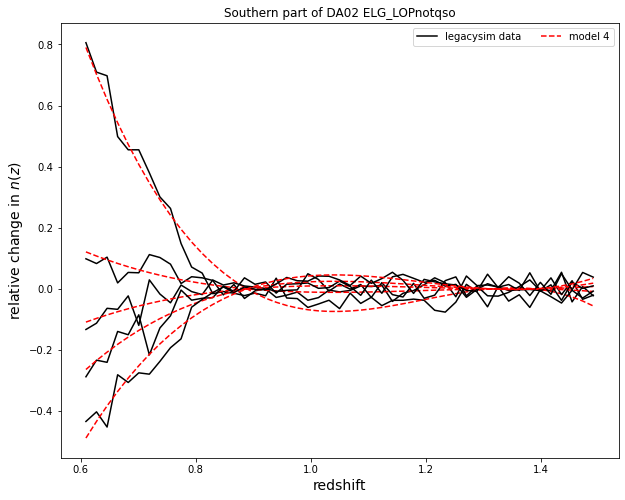

In [32]:
fig = plt.figure(figsize=(10,8))
plt.plot([],[], color='k', label='legacysim data')
plt.plot([],[], color='r', ls='--', label=f'model {4}')

for i in range(5):
    plt.plot(x1[:bins-1], y[(bins-1)*i:(bins-1)*(i+1)], color='k')
    plt.plot(x1_line[:bins-1], y_line[(bins-1)*i:(bins-1)*(i+1)], color='r', ls='--')
    
plt.title('Southern part of DA02 {}'.format(prefix))
plt.ylabel(r'relative change in $n(z)$', fontsize=14)
plt.xlabel(r'redshift',fontsize=14)
plt.legend(loc=1, ncol=2)
plt.show()

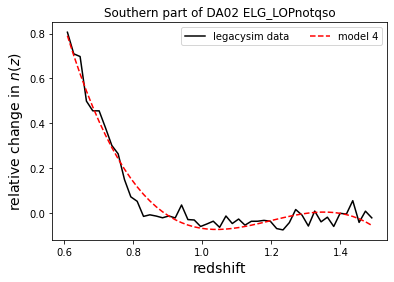

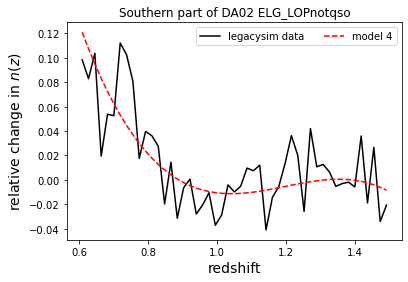

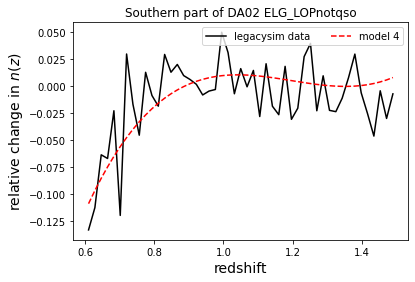

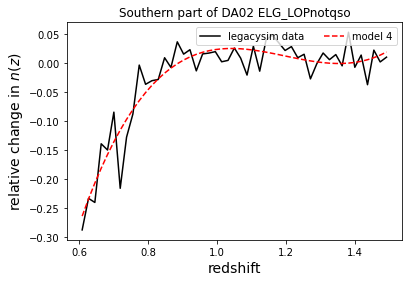

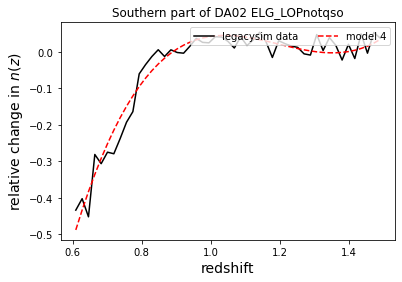

In [20]:
for i in range(5):
    #fig = plt.figure(figsize=(10,8))
    plt.plot([],[], color='k', label='legacysim data')
    plt.plot([],[], color='r', ls='--', label=f'model {4}')
    
    plt.plot(x1[:bins-1], y[(bins-1)*i:(bins-1)*(i+1)], color='k')
    plt.plot(x1_line[:bins-1], y_line[(bins-1)*i:(bins-1)*(i+1)], color='r', ls='--')
    
    plt.title('Southern part of DA02 {}'.format(prefix))
    plt.ylabel(r'relative change in $n(z)$', fontsize=14)
    plt.xlabel(r'redshift',fontsize=14)
    plt.legend(loc=1, ncol=2)
    plt.show()

# Implement model 4 for predicting dndz

In [6]:
def objective4(X, a, b, c, d, e, f, g, h):
    x1, x2 = X
    return (a*x1 + b*x1**2 + c*x1**3 + d) * (e*x2 + f*x2**2 + g*x2**3 + h)

In [40]:
def plot_dndz_variations_test4(ax, z, depth, samples, weights=None, zbins=np.linspace(0.6, 1.5, 18), linestyle='-', labels=None):

    usamples = np.unique(samples)
    nsamples = len(usamples)
    if labels is None:
        labels = [None]*nsamples
    
    dndzw = np.histogram(z, bins=zbins, weights=weights)[0]
    dndz = np.histogram(z, bins=zbins)[0]
    perr = 1./np.sqrt(dndz)*np.sqrt(nsamples)
    mid = (zbins[:-1] + zbins[1:])/2.
    ax.fill_between(mid, -perr, perr, color='gray')
    
    z_list = []
    depth_list = []
    dndz_list = []
    pred_list = []
    perr_list = []
    yerr_list = []

    for isample, (sample, label) in enumerate(zip(usamples, labels)):
        mask = samples == sample
        depth_sample = np.full_like(mid, depth[mask].mean())
        dndzw_sample = np.histogram(z[mask], bins=zbins, weights=weights[mask] if weights is not None else None)[0]
        yerr = 1 / np.sqrt(dndzw_sample)
        ratio = dndzw_sample.sum()/dndzw.sum()
        toplot =  1./ratio*dndzw_sample/dndzw - 1.
        
        if isample < 5:
            # implement model 4 for fit
            popt, _ = curve_fit(objective4, (mid,depth_sample), toplot)
            pred = objective4((mid,depth_sample), *popt)
            #
            z_list.append(mid)
            depth_list.append(depth_sample)
            dndz_list.append(toplot)
            pred_list.append(pred)
            yerr_list.append(yerr)
            
        ax.plot(mid,toplot, color='C{:d}'.format(isample), linestyle=linestyle, label=label)
      
    #z_list = [mid for i in range(5)]
    z = np.concatenate(z_list)
    depth = np.concatenate(depth_list)
    dndz = np.concatenate(dndz_list)
    pred = np.concatenate(pred_list)
    yerr
    
    ax.set_xlabel('redshift')
    ax.set_ylabel('relative change in n(z)')
    ax.grid(True)
    ax.set_ylim(-0.3, 0.3)
    #print(dndz_list)
    return z, depth, dndz, pred

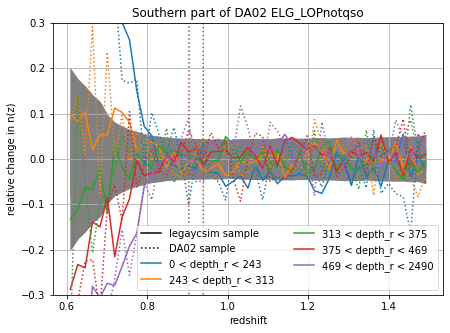

In [41]:
for prefix in ['ELG_LOPnotqso']:#,'ELG']:
    for column, name in [('GALDEPTH_R', 'depth_r')]:#, ('GALDEPTH_G', 'depth_g'), ('EBV', 'ebv')][:-1]:
        z = legacysim_data['INPUT_HSC_MIZUKI_PHOTOZ_BEST']
        depth = legacysim_data[column]
        quantiles = np.quantile(depth, q=np.linspace(0., 1., 6))
        #print(quantiles)
        labels = ['{:.0f} < {} < {:.0f}'.format(low, name, high) for low, high in zip(quantiles[:-1], quantiles[1:])]
        #print(labels)
        samples = np.clip(np.digitize(depth, quantiles) - 1, 0, len(quantiles) - 1)
        
        ax = plt.gca()
        fig = plt.gcf()
        fig.set_size_inches(7, 5)
        ax.plot([], [], linestyle='-', color='k', label='legaycsim sample')
        ax.plot([], [], linestyle=':', color='k', label='DA02 sample')
        z_binned, depth_binned, dndz_binned1, pred_binned1 = plot_dndz_variations_test2(ax, z, depth, samples, zbins=np.linspace(0.6, 1.5, bins), linestyle='-', labels=labels)
        
        # implement model 4 for fit
        #popt, _ = curve_fit(objective4, (z_binned,depth_binned), dndz_binned)
        #pred1 = objective4((z_binned, depth_binned), *popt)
        #
        
        data_full = data
        data_clustering = Catalogue.load(os.path.join(base_dir, '{}zdone_clustering.dat.fits'.format(prefix)))
        ind1, ind2 = utils.overlap(data_clustering['TARGETID'], data_full['TARGETID'])
        data_clustering = data_clustering[ind1]
        z = data_clustering['Z']
        weights = data_clustering['WEIGHT_COMP']
        depth = data_full[column][ind2]
        samples = np.clip(np.digitize(depth, quantiles) - 1, 0, len(quantiles) - 1)
        z_binned, depth_binned, dndz_binned2, pred_binned2 = plot_dndz_variations_test2(ax, z, depth, samples, zbins=np.linspace(0.6, 1.5, bins), weights=weights, linestyle=':')
        
        # implement model 4 for fit
        #popt, _ = curve_fit(objective4, (z_binned,depth_binned), dndz_binned)
        #pred2 = objective4((z_binned, depth_binned), *popt)
        #
        
        ax.set_title('Southern part of DA02 {}'.format(prefix))

        ax.legend(loc=4, ncol=2)
        filename = os.path.join(plot_dir, 'dndz_{}_{}_{}.png'.format(prefix, run, name))
        #fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=200)
        plt.show()

Looking at the figure below, fitting using optimal values obtained from legacysim data seem to give better dndz predictions. 

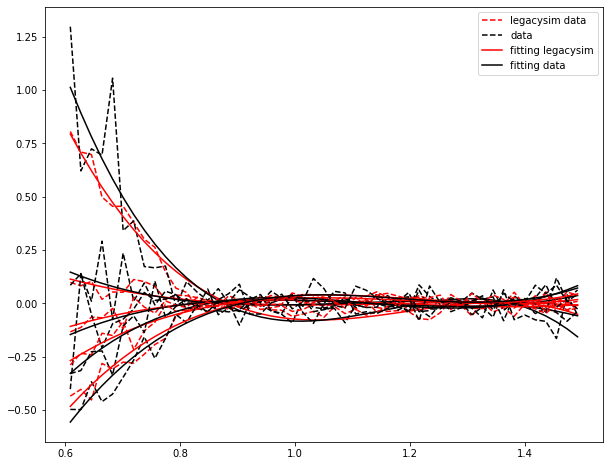

In [42]:
fig = plt.figure(figsize=(10,8))

plt.plot([],[],color='r',ls='--',label='legacysim data')
plt.plot([],[],color='k',ls='--',label='data')

plt.plot([],[],color='r',label='fitting legacysim')
plt.plot([],[],color='k',label='fitting data')
for i in range(5):
    plt.plot(z_binned[:(bins-1)], dndz_binned1[(bins-1)*i:(bins-1)*(i+1)], ls='--', color='r')
    plt.plot(z_binned[:(bins-1)], dndz_binned2[(bins-1)*i:(bins-1)*(i+1)], ls='--', color='k')
    
    plt.plot(z_binned[:(bins-1)], pred_binned1[(bins-1)*i:(bins-1)*(i+1)], color='r')
    plt.plot(z_binned[:(bins-1)], pred_binned2[(bins-1)*i:(bins-1)*(i+1)], color='k')
plt.legend()

# Implement model 2 for predicting dndz

In [44]:
def objective2(X, a, b, c):
    x1, x2 = X
    return (x2 + a) * np.exp(-b*x1) + c

[ 5.16927685e+01  9.10878677e+00 -4.44443920e-02]


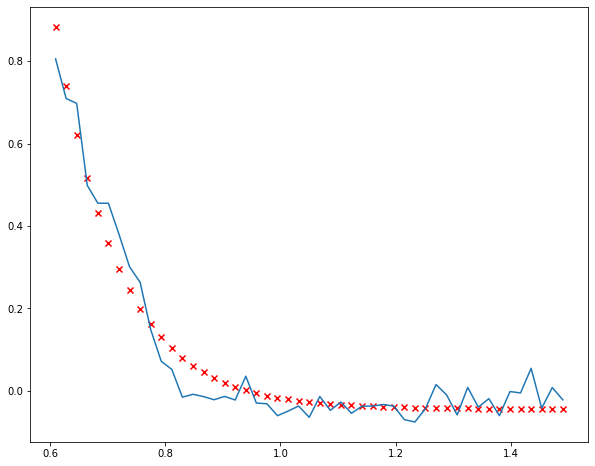

In [33]:
# here we are trying out model 2 seems to fit only one depth bin at a time
fig = plt.figure(figsize=(10,8))

# choose the input and output variables
x1, x2, y = t['z'], t[f'{name}'], t['dndz']

#define a sequence of inputs between the smallest and largest known inputs
z_line = np.linspace(0.6, 1.5, bins)
depth_line = np.full_like(z_line, x2[0])

i, j = (bins-1)*0, (bins-1)*1

popt, _ = curve_fit(objective2, (x1[i:j],x2[i:j]), y[i:j])
#popt, _ = curve_fit(objective2, (x1,x2), y)
print(popt)

y_line = objective2((x1[i:j],x2[i:j]), *popt)

plt.plot(x1[i:j],y[i:j])
#plt.plot(x1,y)
plt.scatter(x1[i:j], y_line, marker='x', color='r')
#plt.ylim(-.8,.8)

In [45]:
def plot_dndz_variations_test2(ax, z, depth, samples, weights=None, zbins=np.linspace(0.6, 1.5, 18), linestyle='-', labels=None):

    usamples = np.unique(samples)
    nsamples = len(usamples)
    if labels is None:
        labels = [None]*nsamples
    
    dndzw = np.histogram(z, bins=zbins, weights=weights)[0]
    dndz = np.histogram(z, bins=zbins)[0]
    perr = 1./np.sqrt(dndz)*np.sqrt(nsamples)
    mid = (zbins[:-1] + zbins[1:])/2.
    ax.fill_between(mid, -perr, perr, color='gray')
    
    z_list = []
    depth_list = []
    dndz_list = []
    pred_list = []

    for isample, (sample, label) in enumerate(zip(usamples, labels)):
        mask = samples == sample
        depth_sample = np.full_like(mid, depth[mask].mean())
        dndzw_sample = np.histogram(z[mask], bins=zbins, weights=weights[mask] if weights is not None else None)[0]
        ratio = dndzw_sample.sum()/dndzw.sum()
        toplot =  1./ratio*dndzw_sample/dndzw - 1.
        
        if isample < 5:
            # implement model 2 for fit
            popt, _ = curve_fit(objective2, (mid,depth_sample), toplot)
            pred = objective2((mid,depth_sample), *popt)
            #
            z_list.append(mid)
            depth_list.append(depth_sample)
            dndz_list.append(toplot)
            pred_list.append(pred)
            
        ax.plot(mid,toplot, color='C{:d}'.format(isample), linestyle=linestyle, label=label)
      
    #z_list = [mid for i in range(5)]
    z = np.concatenate(z_list)
    depth = np.concatenate(depth_list)
    dndz = np.concatenate(dndz_list)
    pred = np.concatenate(pred_list)
    
    ax.set_xlabel('redshift')
    ax.set_ylabel('relative change in n(z)')
    ax.grid(True)
    ax.set_ylim(-0.3, 0.3)
    #print(dndz_list)
    return z, depth, dndz, pred

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

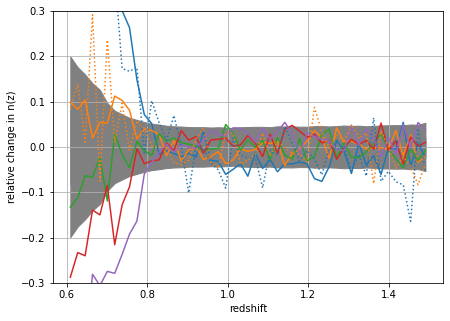

In [46]:
for prefix in ['ELG_LOPnotqso']:#,'ELG']:
    for column, name in [('GALDEPTH_R', 'depth_r')]:#, ('GALDEPTH_G', 'depth_g'), ('EBV', 'ebv')][:-1]:
        z = legacysim_data['INPUT_HSC_MIZUKI_PHOTOZ_BEST']
        depth = legacysim_data[column]
        quantiles = np.quantile(depth, q=np.linspace(0., 1., 6))
        #print(quantiles)
        labels = ['{:.0f} < {} < {:.0f}'.format(low, name, high) for low, high in zip(quantiles[:-1], quantiles[1:])]
        #print(labels)
        samples = np.clip(np.digitize(depth, quantiles) - 1, 0, len(quantiles) - 1)
        
        ax = plt.gca()
        fig = plt.gcf()
        fig.set_size_inches(7, 5)
        ax.plot([], [], linestyle='-', color='k', label='legaycsim sample')
        ax.plot([], [], linestyle=':', color='k', label='DA02 sample')
        z_binned, depth_binned, dndz_binned1, pred_binned1 = plot_dndz_variations_test2(ax, z, depth, samples, zbins=np.linspace(0.6, 1.5, bins), linestyle='-', labels=labels)
        
        # implement model 4 for fit
        #popt, _ = curve_fit(objective4, (z_binned,depth_binned), dndz_binned)
        #pred1 = objective4((z_binned, depth_binned), *popt)
        #
        
        data_full = data
        data_clustering = Catalogue.load(os.path.join(base_dir, '{}zdone_clustering.dat.fits'.format(prefix)))
        ind1, ind2 = utils.overlap(data_clustering['TARGETID'], data_full['TARGETID'])
        data_clustering = data_clustering[ind1]
        z = data_clustering['Z']
        weights = data_clustering['WEIGHT_COMP']
        depth = data_full[column][ind2]
        samples = np.clip(np.digitize(depth, quantiles) - 1, 0, len(quantiles) - 1)
        z_binned, depth_binned, dndz_binned2, pred_binned2 = plot_dndz_variations_test2(ax, z, depth, samples, zbins=np.linspace(0.6, 1.5, bins), weights=weights, linestyle=':')
        
        # implement model 4 for fit
        #popt, _ = curve_fit(objective4, (z_binned,depth_binned), dndz_binned)
        #pred2 = objective4((z_binned, depth_binned), *popt)
        #
        
        ax.set_title('Southern part of DA02 {}'.format(prefix))

        ax.legend(loc=4, ncol=2)
        filename = os.path.join(plot_dir, 'dndz_{}_{}_{}.png'.format(prefix, run, name))
        #fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=200)
        plt.show()

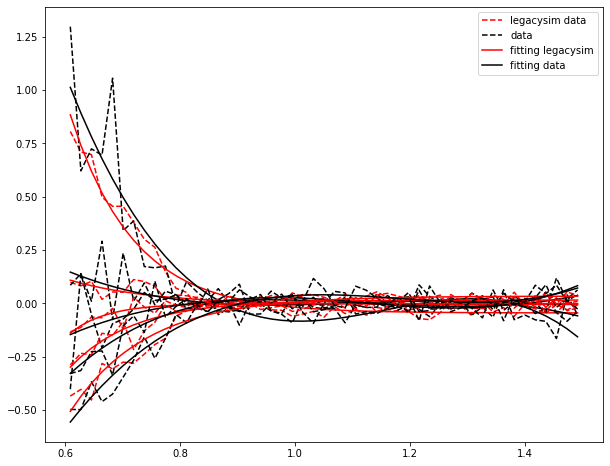

In [47]:
fig = plt.figure(figsize=(10,8))

plt.plot([],[],color='r',ls='--',label='legacysim data')
plt.plot([],[],color='k',ls='--',label='data')

plt.plot([],[],color='r',label='fitting legacysim')
plt.plot([],[],color='k',label='fitting data')
for i in range(5):
    plt.plot(z_binned[:(bins-1)], dndz_binned1[(bins-1)*i:(bins-1)*(i+1)], ls='--', color='r')
    plt.plot(z_binned[:(bins-1)], dndz_binned2[(bins-1)*i:(bins-1)*(i+1)], ls='--', color='k')
    
    plt.plot(z_binned[:(bins-1)], pred_binned1[(bins-1)*i:(bins-1)*(i+1)], color='r')
    plt.plot(z_binned[:(bins-1)], pred_binned2[(bins-1)*i:(bins-1)*(i+1)], color='k')
plt.legend()